# Ejemplo para el cálculo de costes de reparacion en el grado de desarrollo de proyecto de inversión: Parte 1 - Lectura de los datos de entrada.

## Importación de paquetes de IPython

In [1]:
# hidden
import environment as env
env.initialize()

In [2]:
# Python 2/3 setup 
from __future__ import (absolute_import, division, print_function, unicode_literals)
# from builtins import *

In [3]:
# Juypyter setup

%matplotlib inline
import os
import sys
from IPython.display import HTML

In [4]:
sim_path = os.path.join(env.modules_path ,'AP_PI_reparacion_est_conservadora', 'datos', 'sim_01')

if sim_path not in sys.path:
    sys.path.append(sim_path)

## Importación de paquetes para el ejemplo

In [5]:
import logging
import os
import pickle

from reparacion.datos_entrada import datos_entrada_planta
from reparacion.datos_entrada import datos_entrada_diagrama_modos
from reparacion.datos_entrada import datos_entrada_arbol_fallo
from reparacion.datos_entrada import datos_entrada_esquema_division_dique
from reparacion.datos_entrada import datos_entrada_clima_tramos
from reparacion.datos_entrada import datos_entrada_verificacion_dique

from reparacion.calculos import extraccion_resultados
from reparacion.calculos import calculo_costes

from reparacion.datos_entrada import datos_entrada_elementos_reparacion_necesarios
from reparacion.datos_entrada import datos_entrada_elementos_reparacion_disponibles
from reparacion.datos_entrada import datos_entrada_tipo_verificacion


#### NOTA: MODIFICACIÓN MODULES PATH

## Datos de entrada de la forma en planta

### RUTA DE DIRECTORIOS DE DATOS DE ENTRADA Y SALIDA


In [6]:
# Ruta con los datos de entrada
ruta_de = os.path.join(env.input_path, 'reparacion', 'proyecto_inversion')
# Ruta con los datos de salida
ruta_ds = os.path.join(env.output_path, 'reparacion', 'proyecto_inversion')

### INTRODUCCION

De acuerdo con el articulado de la ROM 1.1 en el grado de desarrollo de proyecto de inversión se deben calcular los costes completos de las fases de reparación del dique a lo largo de la vida útil. Para el cálculo de estos costes se deberán considerar lo siguiente:
- El cálculo de costes deberá realizarse mediante  la verificación simultánea de todos los modos de fallo de los distintos componentes del dique.
- Se considearará un diseño a Estado Límite de Servicio en el que la avería de los distintos modos podrá progresar en el tiempo utilizando para ello una curva de acumulación de daño.
- La verificación deberá realizarse en cada uno de los estados de las series climáticas debiendose considerar tanto los periodos de calma como los ciclos de solicitación
- Se deberán definir las estrategias de reparación en su máximo nivel de precisión sin permitir ambigüedad.
- El método para verificar el comportamiento de la obra en el este alcance es por métodos de Nivel III empleándose técnicas de simulación mediante técnicas de Monte Carlo para obtener nuevas series climáticas y repetir así la verificación un número elevado de veces que permita acotar la incertidumbre asociadas a los costes.

A modo de resumen, el cálculo de costes de reparación en este grado de desarrollo:
- Considera un número elevado de series climáticas para obtner así los costes medios de reparación junto con su variabilidad asociada
- No considera la reparación inmediata de los daños sufridos en cada modo, sino que el daño progresa en el tiempo hasta que es den las condiciones necesarias para efectuar las labores de reparación
- Se podrán definir varias estrategias de reparación en función de los parámetros de entrada a definir
- Se considera que el progreso de la avería en uno de los modos puede inducir el desencadenamiento del fallo en otros modos.
- Se podrá diferencias entre elementos necesarios para la reparación y elementos disponibles en puerto de forma permanente para efectuar los trabajos de reparación.
- En la verificación de los modos a ELS se considera la evolución del daño mediante las curvas de acumulación de daño.
- Se considerará que le dique puede fallar en su conjunto mediante las diferentes configuraciones de fallo definidas en el diagrama de componentes.

A modo de ejemplo se muestra a continuación los datos de entrada, la verificación mediante simulación numérica y la obtención de los costes de reparación para una de las 25 simulaciones consideradas. Finalmente se mostrarán algunas gráficas con los resultados integrados de las 25 simulación

### DEFINICIÓN DEL ALCANCE Y ESTRATEGIA

In [7]:
alcance = 'PI'

#estrategia = 'no_reparacion'
#estrategia = 'reparacion_inmediata'
estrategia = ''


### DEFINICIÓN DE LOS DATOS DE ENTRADA

En este ejemplo se propone analizar el coste de un dique de tipo mixto con berma baja de protección (Tipo C, LMB). La sección tipo del dique a analizar se muestra en la figura. En este ejemplo, se considera para la forma en planta un dique compuesto por una única alineación principal de 500 m de longitud. El calado de la alineación principal es de 16 m respecto al nivel medio del mar, la altura de la berma es de 4 m y los cajones tienen una altura de 18 m por 12 m de ancho.

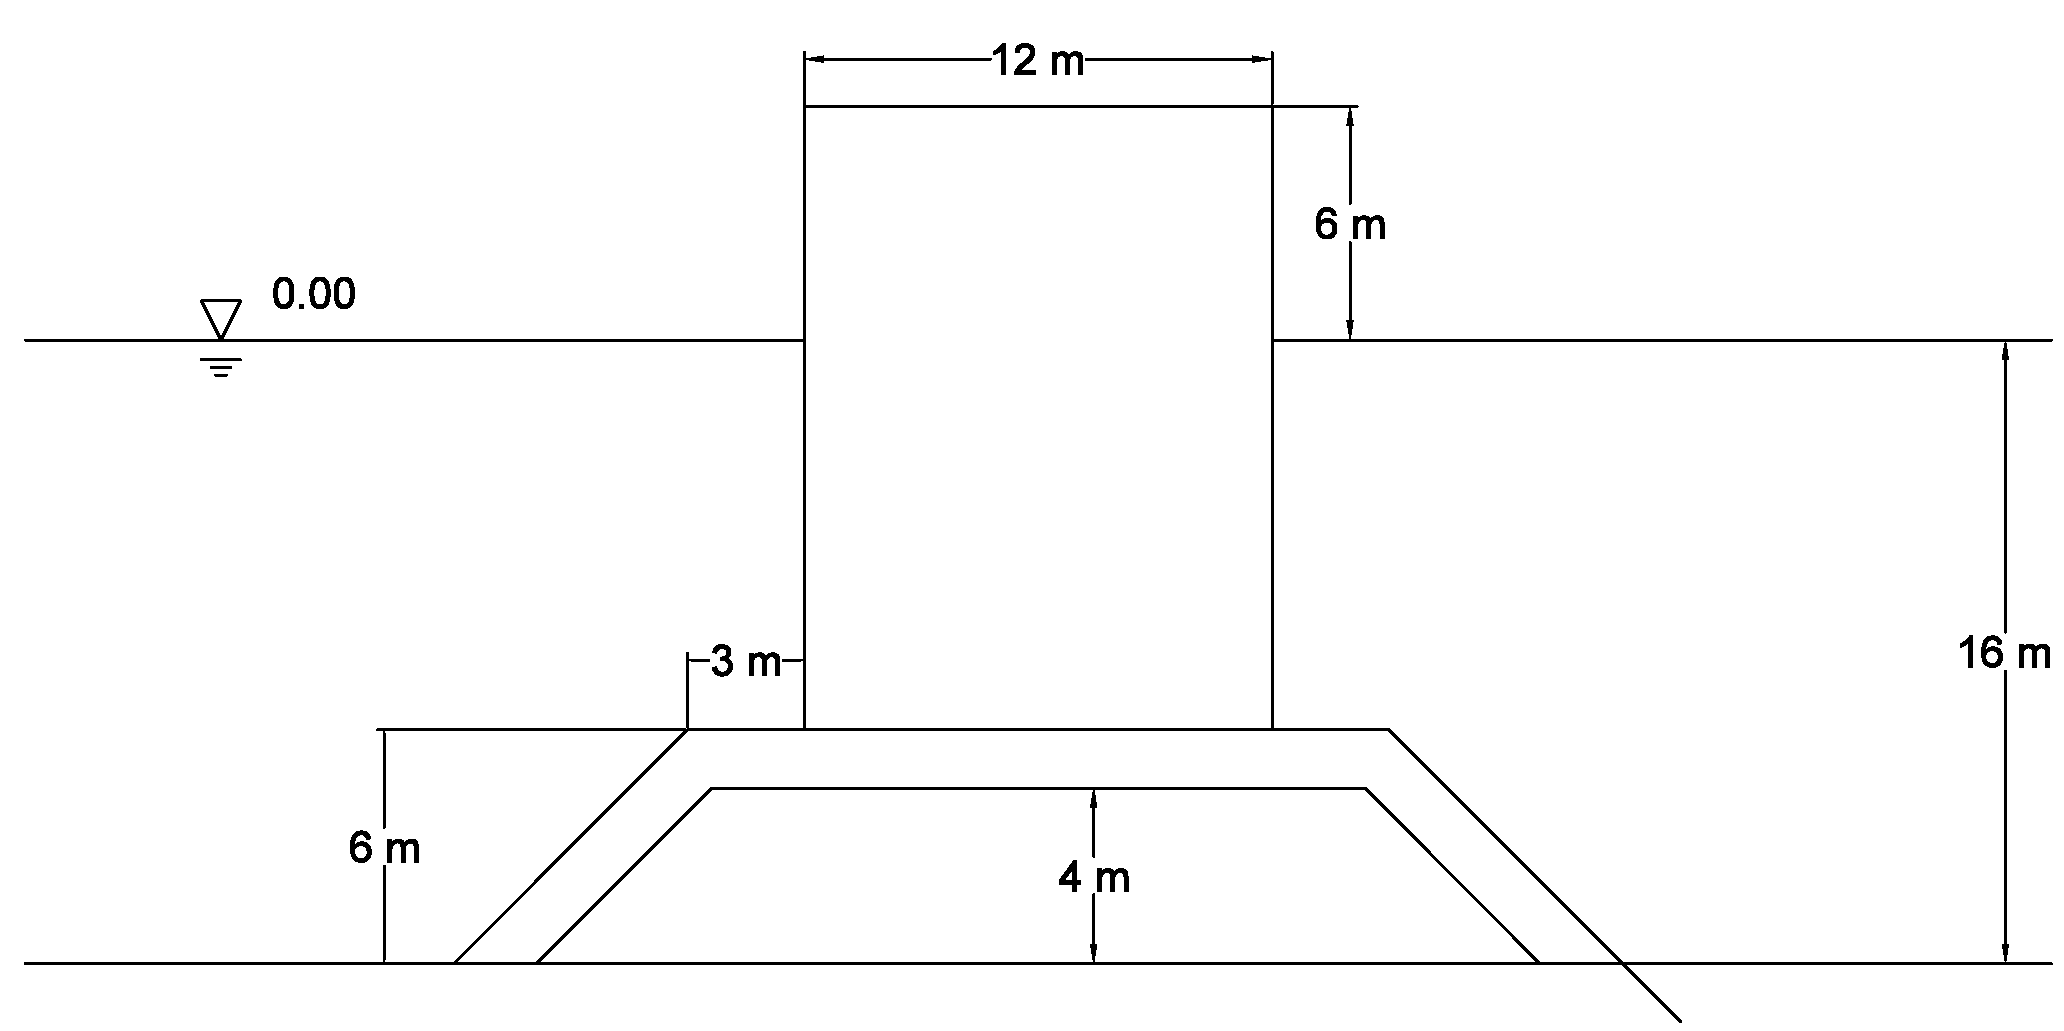

In [8]:
from IPython.display import Image
img_name = os.path.join(ruta_de, 'imagenes', 'esquema_dique_c.png')
Image(filename=img_name, width=800)

#### Lectura de los ficheros con los datos de entrada de tipología y forma en planta
(Para modificar los datos utilizados en el ejemplo se deben modificar los ficheros de la carpeta de inputs)

A modo de ejemplo se simulará una vida útil de 5 años. 

In [9]:
# Lectura de los datos de entrada en planta
(de_planta) = datos_entrada_planta(ruta_de)

de_planta


longitud  vida_util  calado
T_0     500.0        5.0    15.0

#### Lectura de los ficheros con los datos de entrada del esquema de componentes
De acuerdo con el articulado la estructura jerárquica del dique se descompone en: tramos, subsistemas y modos de fallo. En este ejemplo teórico se muestra el cálculo de costes de un tramo compuesto por un subsistema con un único modo de fallo.

In [10]:
    # lectura del esquema de division del dique
    (de_esquema_division_dique) = datos_entrada_esquema_division_dique(ruta_de)
    de_esquema_division_dique

tramo subsistema modo_fallo
0   T_0       SS_0       MF_3

#### Lectura de los ficheros con los datos de entrada del diagrama de componentes
De acuerdo con el articulado de la ROM 1.1. los diagramas de componentes expresan las posibles combinaciones de elementos del espacio de sucesos que suponen el incumplimiento de los requisitos del sistema. Los tipos de diagramas pueden ser: tipo serie (en el que el sistema falla si lo hace al menos uno de los componentes), tipo paralelo (el sistema falla si lo hacen todos los componentes) o tipo mixto (mezcla de ambos).

Para este ejemplo se ha definido un diagrama para cada estructura jerárquica del dique:

- Diagrama de modos del dique: En el que se indican las posibles combinaciones de tramos que deben fallar para considera el fallo del dique. En este ejemplo se considera que el dique falla si falla el tramo $T\_0$.
- Diagrama de modos de los tramos: En el que se indican las posibles combinaciones de subsistemas que deben fallas para considerar el fallo del tramo. En este ejemplo se considera que el tramo falla si falla el subsistema $SS\_0$.
- Diagrama de modos de los subsistemas: En el que se indican las posibles combinaciones de modos que deben fallar para considerar el fallo de un subsistema. Para este ejemplo se ha considerado un diagrama de modos en el que el fallo del subsistema se produce si falla el $MF\_3$.


In [11]:
# Lectura de los datos de entrada del diagrama de modos
(de_diagrama_modos) = datos_entrada_diagrama_modos(ruta_de)
de_diagrama_modos['de_diagrama_modos_dique']

opciones_de_destruccion_total
Dique  op1                       ['T_0']

In [12]:
de_diagrama_modos['de_diagrama_modos_tramos']

opciones_de_destruccion_total
T_0 op1                      ['SS_0']

In [13]:
de_diagrama_modos['de_diagrama_modos_subsistemas']

opciones_de_destruccion_total
T_0 SS_0 op2                      ['MF_3']

#### Lectura de los datos climáticos

Dentro de la carpeta ’clima’ es necesario que haya una carpeta por cada uno de los tramos
que componen el dique con el nombre de la etiqueta del tramo (en este caso únicamente uno). Dentro de cada carpeta se debe
encontrar un fichero denominado ’clima.txt’ con las series temporales históricas propagadas al
emplazamiento de cada uno de los agentes necesarios para realizar la verificación del dique. Las
series temporales se estructurarán por columnas.

La matriz con los datos de clima tendrán un valor de nivel (respecto al NMM), velocidad de viento, altura de ola, periodo pico, dirección media de procedendia del oleaje y dirección media de procedencia del viento para cada hora.

Se muestra a continuación un ejemplo del fichero de clima:

In [14]:
# Lectura de los datos de clima para cada tramo
(clima_tramos, cadencia) = datos_entrada_clima_tramos(de_esquema_division_dique, de_planta, ruta_de)

# Cambio el numero de filas y columnas que se muestran 
env.pandas_setup(10, 50)
display(clima_tramos['T_0'])
# Cambio el numero de filas y columnas a sus valores por defecto
env.pandas_setup()

nivel         vv        hs         tp          dh          dv  \
0     -0.187445   3.531673  0.572556   7.974521  260.433608  221.654369   
1      0.464185   7.230433  0.772869   9.380499  264.472435  352.096121   
2      0.125255   1.403388  0.596432   7.893324  256.241187  140.491183   
3     -0.523136   4.437268  1.258365   9.176988  262.288329  171.496462   
4     -0.261880   2.736062  0.552534  10.674567  254.761802   64.307393   
...         ...        ...       ...        ...         ...         ...   
29211 -0.036775   5.943159  0.046617  10.899674  238.902541   22.980948   
29212 -0.573777  10.167237  0.036173   7.895515  250.807646  111.394604   
29213 -0.162674   7.576738  0.146799   6.737357  253.179053   25.544986   
29214  0.464816   4.531977  0.306809   5.750664  258.426859  325.263397   
29215  0.039940   7.444838  0.284937   5.000000  255.795818  120.747631   

            mas       mme     calado  
0      1.595942 -0.057643  14.812555  
1      2.258235 -0.068305  15.464185  
2      1.912683 -0.061684  15.125255  
3      1.257457 -0.054848  14.476864  
4      1.521742 -0.057878  14.738120  
...         ...       ...        ...  
29211  1.758231 -0.069262  14.963225  
29212  1.215802 -0.063835  14.426223  
29213  1.630499 -0.067428  14.837326  
29214  2.265278 -0.074718  15.464816  
29215  1.833988 -0.068303  15.039940  

[29216 rows x 9 columns]

#### Lectura de datos de entrada del tipo de verificación para cada modo de fallo
De acuerdo con el Articulado de la ROM 1.1 en el alcance de proyecto de inversión se deben calcular los costes completos de reparación a partir de un diseño de ELS según la configuración del diagrama de modos de fallo del dique. Por lo tanto dentro de la carpeta 'tipo_verificacion_curva_acum_dano' el fichero 'tipo_verificacion_curva_acum_dano.txt' le indicará a la herramienta que cada modo de fallo se verifica a ELS y por lo tanto será necesario especificar los parámetros de la curva de acumulación de daño. Si se desease realizar una verificación a ELU bastaría con modificar el parámetro a ELU e igualar para cada modo los parámetros a, b y c de curva de acumulación de daño a 0.

Se muestra a continuación un ejemplo con los ficheros de entrada para el tipo de verificación para cada modo de fallo:


In [15]:
# Tipo de verificacion y curva de acumulacion de dano
de_tipo_verificacion = datos_entrada_tipo_verificacion(ruta_de)

de_tipo_verificacion

tipo_diseno    par_a   par_b   par_c
T_0 SS_0 MF_3         els  0.00013  0.3935  3.1816

Se muestra a continuación la curva de acumulación de daño utilizada junto con sus parámetros de ajuste para este ejemplo.

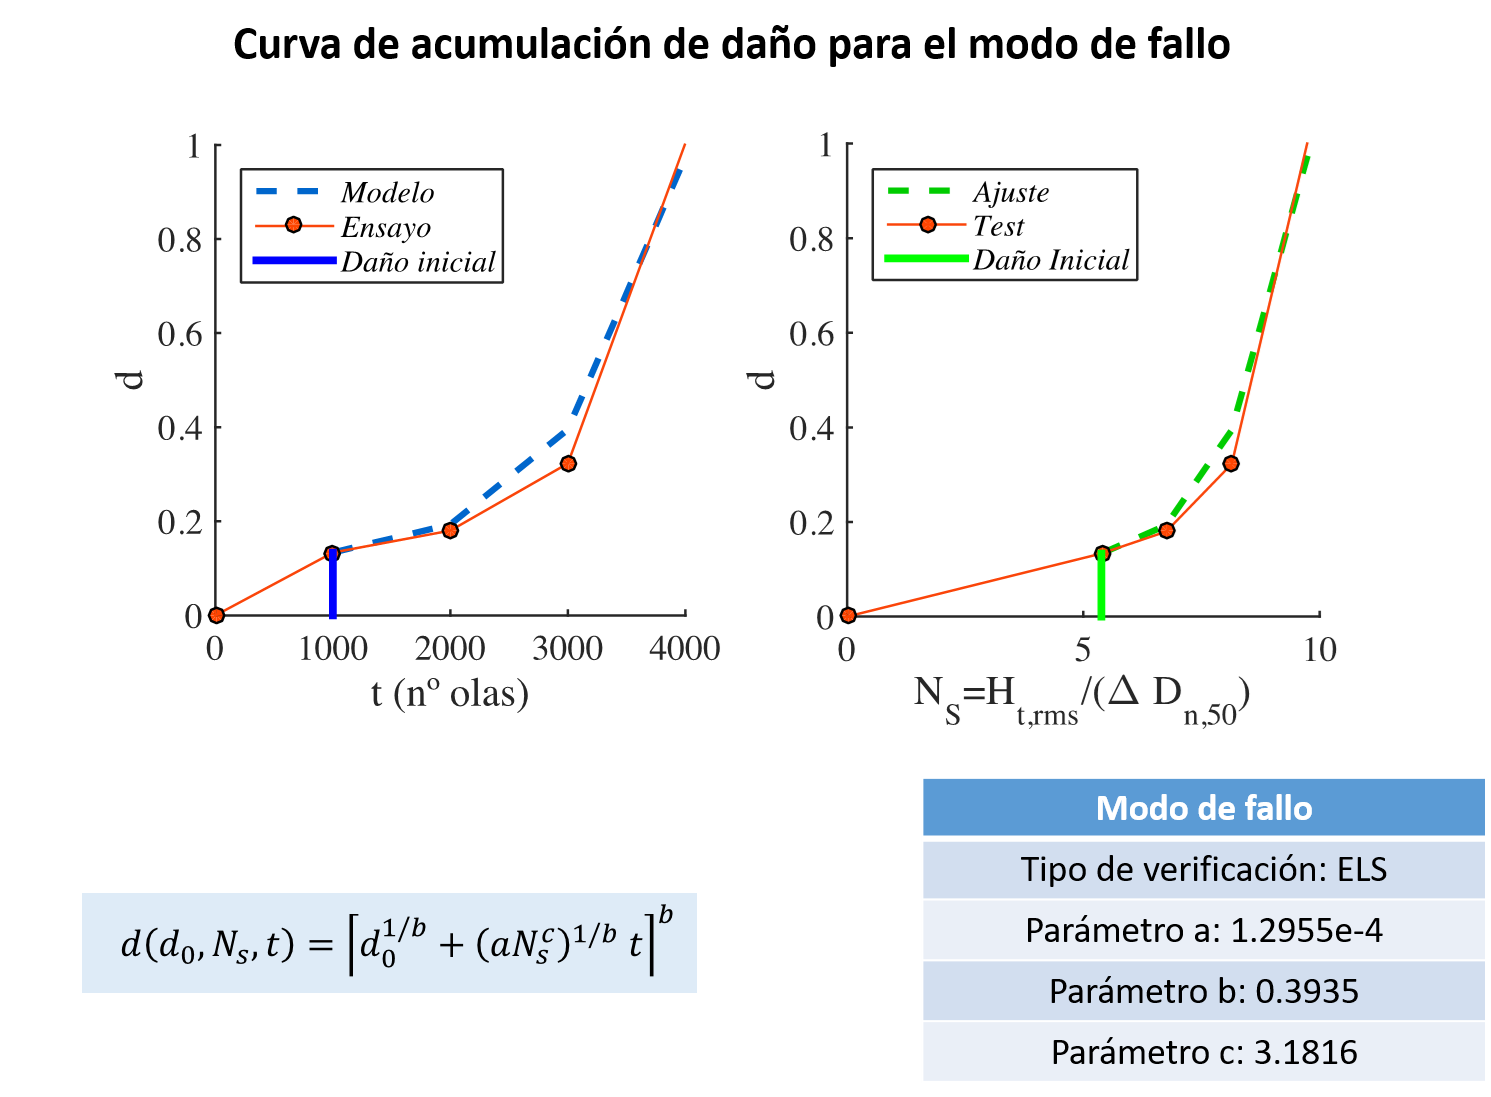

In [16]:
from IPython.display import Image
img_name = os.path.join(ruta_de, 'imagenes', 'curva_acumulacion_daño.png')
Image(filename=img_name, width=800)

Además se debe leer los resultados del módulo de verificación en el que se indica para cada estado de mar de la vida útil si cada uno de los modos de fallo fallan o no fallan

In [17]:
    # Verificacion tramos del dique
    (de_verificacion_tramos, peralte) = datos_entrada_verificacion_dique(ruta_de, de_esquema_division_dique)
    de_verificacion_tramos.loc[:, ('T_0', 'SS_0', 'MF_3')]

0        False
1        False
2        False
3        False
4        False
         ...  
14595    False
14596    False
14597    False
14598    False
14599    False
Name: (T_0, SS_0, MF_3), Length: 14600, dtype: object

#### Lectura de los datos de entrada con la estrategia de reparación
Para cada modo de fallo es necesario especificar los distintos parámetros de reparación que definen la estrategia, entre los que se incluyen los siguientes:
- Nivel de avería umbral para iniciar la reparción: Se considera un valor de 0.5
- Nivel de avería umbral para finalizar la reparación: Se considera un valor de 0
- Maquinaria necesaria para llevar a cabo la reparación del modo
    - Tipo de maquinaria: Camión y gánguil
    - Tiempo necesario que debe transcurrir desde que se da la orden de reparar hasta que se consigue la maquinaria necesaria: 24 h
    - Umbral de operatividad de la maquinaria: Para el gánguil se considera que éste puede trabajar siempre que la altura de ola sea menor que 1.5 m y el calado superior a 3 m.
    - Costes unitario por hora de trabajo de cada máquina: 25 y 80 $\mathrm{\geneuro \, h^{-1}}$ respectivamente.
- Materiales necesarios para llevar a cabo la reparación del modo
    - Tipo de materiales: Todo uno de cantera
    - Cantidad total de materiales necesarios durante la reparación del modo: 300 $\mathrm{m^3}$
    - Tiempo necesario que debe transcurrir desde que se da la orden de reparar hasta que se consigue los materiales necesarios: 0 h
    - Coste total de los materiales durante un evento de reparación: 3000 $\mathrm{\geneuro}$
- Mano de obra necesaria para llevar a cabo la reparación del modo
    - Tipo de mano de obra: Operarios
    - Tiempo necesario que debe transcurrir desde que se da la orden de reparar hasta que se consigue la mano de obra necesaria: 24 h
    - Costes unitario por hora de trabajo de cada mano de obra: 10 $\mathrm{\geneuro \, h^{-1}}$ respectivamente.
- Rendimiento de reparación de la avería en base a los medios definidos: 0.001 (tanto por uno) de avería reparado en cada hora.

No se consideran elementos permanentes en puerto para los trabajos de reparación.

In [18]:
    # Datos de entrada de reparacion necesario
    de_reparacion_necesarios = datos_entrada_elementos_reparacion_necesarios(ruta_de, cadencia, alcance,
                                                                             estrategia)
    # Datos de entrada de reparacion disponibles
    de_reparacion_disponibles = datos_entrada_elementos_reparacion_disponibles(ruta_de, cadencia, alcance)
    
    # Cambio el numero de filas y columnas que se muestran 
    env.pandas_setup(10, 50)
    display(de_reparacion_necesarios)
    # Cambio el numero de filas y columnas a sus valores por defecto
    env.pandas_setup()

na_umbral_ini_reparacion na_umbral_fin_reparacion  \
T_0 SS_0 MF_3                      0.3                        0   

                       tipos_maq num_maq           tipos_mat cant_mat  \
T_0 SS_0 MF_3  [ganguil, camion]  [2, 5]  [todo_uno_cantera]    [300]   

                  tipos_mo num_mo t_maq_ini_rep t_mat_ini_rep t_mo_ini_rep  \
T_0 SS_0 MF_3  [operarios]   [15]            24             0           24   

                                                         umb_ope   rend  \
T_0 SS_0 MF_3  {'calado': 3, 'hs': 1.5, 'vv': 100, 'nivel': 100}  0.001   

              coste_maq_rep coste_mat_rep coste_mo_rep  
T_0 SS_0 MF_3           855          3000          450

#### Lectura de los datos de entrada de árbol de desencadenamiento y propagación del fallo
En este alcance es necesario especificar árboles de desencadenamiento y propagación del fallo. Sin embargo, al tratarse de un ejemplo en el que sólo se considera un modo de fallo, el progreso de la avería en dicho modo no puede desencadenar el fallo en otros modos.

In [19]:
# Lectura de los datos de entrada de arbol de fallo
(de_arbol_fallo) = datos_entrada_arbol_fallo(alcance, de_esquema_division_dique, ruta_de)
de_arbol_fallo

modos nivel_averia
T_0 SS_0 MF_3    []           []

## Guardado de las variables

In [20]:
# Saving the objects:
dir_data = os.path.join(env.data_path, 'reparacion', 'proyecto_inversion', 'var_co_costes_reparacion_01_pi.pkl')

with open(dir_data, 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([ruta_de, ruta_ds, alcance, estrategia, de_planta, de_esquema_division_dique, de_diagrama_modos, clima_tramos, cadencia,
                 de_tipo_verificacion, de_verificacion_tramos, peralte, de_reparacion_necesarios, de_reparacion_disponibles, de_arbol_fallo], f)

Continuar con [Parte 2 - Verificación simultánea de todos los modos de fallo principales a lo largo de la vida útil.](co_costes_reparacion_02_pi.ipynb).
